In [5]:
import torch
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision.models import ResNet18_Weights

# 设备设置
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 数据增强和预处理
train_transform_aug = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.5, 1.0)),  # 随机裁剪并调整大小
    transforms.RandomHorizontalFlip(),  # 随机水平翻转
    transforms.RandomRotation(10),  # 随机旋转
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),  # 随机颜色抖动
    transforms.ToTensor(),  # 转换为张量
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 标准化
])

train_transform_no_aug = transforms.Compose([
    transforms.Resize((224, 224)),  # 调整大小
    transforms.ToTensor(),  # 转换为张量
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 标准化
])

val_transform = transforms.Compose([
    transforms.Resize(256),  # 调整大小
    transforms.CenterCrop(224),  # 中心裁剪
    transforms.ToTensor(),  # 转换为张量
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 标准化
])

# 加载数据集
train_data_aug = datasets.ImageFolder('a5_data/train', transform=train_transform_aug)
train_data_no_aug = datasets.ImageFolder('a5_data/train', transform=train_transform_no_aug)
val_data = datasets.ImageFolder('a5_data/val', transform=val_transform)

train_loader_aug = DataLoader(train_data_aug, batch_size=32, shuffle=True)
train_loader_no_aug = DataLoader(train_data_no_aug, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)



In [6]:
# 定义模型
class SimpleCNN(nn.Module):
    def __init__(self, use_bn=False, use_residual=False):
        super(SimpleCNN, self).__init__()
        self.use_residual = use_residual
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64) if use_bn else nn.Identity()
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128) if use_bn else nn.Identity()
        self.fc = None  # 动态计算全连接层输入维度

        # 残差连接的1x1卷积
        if use_residual:
            self.residual_conv = nn.Conv2d(3, 128, kernel_size=1, stride=2)

    def forward(self, x):
        residual = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)  # 224x224 -> 112x112
        x = self.conv2(x)
        x = self.bn2(x)
        if self.use_residual:
            residual = self.residual_conv(residual)  # 调整残差连接的形状
            x += residual
        x = self.relu(x)
        x = x.view(x.size(0), -1)  # 展平

        # 动态计算全连接层的输入维度
        if self.fc is None:
            self.fc = nn.Linear(x.size(1), 2).to(x.device)
        x = self.fc(x)
        return x



In [7]:
# 训练函数
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, scheduler=None):
    train_losses, val_losses, val_accuracies = [], [], []
    best_val_accuracy = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        
        # 验证集评估
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss /= len(val_loader)
        val_accuracy = correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
        
        # # 保存最佳模型
        # if val_accuracy > best_val_accuracy:
        #     best_val_accuracy = val_accuracy
        #     torch.save(model.state_dict(), 'best_model.pth')
        #     print(f"Saved best model with validation accuracy: {val_accuracy:.4f}")
        
        # # 更新学习率
        # if scheduler is not None:
        #     scheduler.step()
    
    return train_losses, val_losses, val_accuracies



In [8]:
# 对比实验
num_epochs = 100
results = {}

# 基线模型（无归一化、无残差连接、无数据增强）
model = SimpleCNN(use_bn=False, use_residual=False).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.00005)
criterion = nn.CrossEntropyLoss()
train_losses, val_losses, val_accuracies = train_model(model, train_loader_no_aug, val_loader, criterion, optimizer, num_epochs)
results['Baseline'] = {'train_loss': train_losses, 'val_loss': val_losses, 'val_accuracy': val_accuracies}



Epoch 1/100, Train Loss: 0.5765, Val Loss: 0.5358, Val Accuracy: 0.7069
Epoch 2/100, Train Loss: 0.4817, Val Loss: 0.5042, Val Accuracy: 0.7396
Epoch 3/100, Train Loss: 0.4538, Val Loss: 0.4891, Val Accuracy: 0.7492
Epoch 4/100, Train Loss: 0.4403, Val Loss: 0.4797, Val Accuracy: 0.7508
Epoch 5/100, Train Loss: 0.4312, Val Loss: 0.4743, Val Accuracy: 0.7564
Epoch 6/100, Train Loss: 0.4248, Val Loss: 0.4700, Val Accuracy: 0.7516
Epoch 7/100, Train Loss: 0.4200, Val Loss: 0.4680, Val Accuracy: 0.7604
Epoch 8/100, Train Loss: 0.4157, Val Loss: 0.4652, Val Accuracy: 0.7596
Epoch 9/100, Train Loss: 0.4121, Val Loss: 0.4628, Val Accuracy: 0.7596
Epoch 10/100, Train Loss: 0.4095, Val Loss: 0.4612, Val Accuracy: 0.7660
Epoch 11/100, Train Loss: 0.4073, Val Loss: 0.4602, Val Accuracy: 0.7596
Epoch 12/100, Train Loss: 0.4053, Val Loss: 0.4597, Val Accuracy: 0.7644
Epoch 13/100, Train Loss: 0.4026, Val Loss: 0.4594, Val Accuracy: 0.7636
Epoch 14/100, Train Loss: 0.4007, Val Loss: 0.4575, Val Accu

In [9]:
# 添加批量归一化
model = SimpleCNN(use_bn=True, use_residual=False).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.00005)
train_losses, val_losses, val_accuracies = train_model(model, train_loader_no_aug, val_loader, criterion, optimizer, num_epochs)
results['With BN'] = {'train_loss': train_losses, 'val_loss': val_losses, 'val_accuracy': val_accuracies}



Epoch 1/100, Train Loss: 0.4616, Val Loss: 0.4562, Val Accuracy: 0.7748
Epoch 2/100, Train Loss: 0.4106, Val Loss: 0.4446, Val Accuracy: 0.7875
Epoch 3/100, Train Loss: 0.3996, Val Loss: 0.4387, Val Accuracy: 0.7947
Epoch 4/100, Train Loss: 0.3868, Val Loss: 0.4293, Val Accuracy: 0.7867
Epoch 5/100, Train Loss: 0.3783, Val Loss: 0.4234, Val Accuracy: 0.7915
Epoch 6/100, Train Loss: 0.3763, Val Loss: 0.4256, Val Accuracy: 0.7939
Epoch 7/100, Train Loss: 0.3673, Val Loss: 0.4221, Val Accuracy: 0.7931
Epoch 8/100, Train Loss: 0.3634, Val Loss: 0.4185, Val Accuracy: 0.7899
Epoch 9/100, Train Loss: 0.3605, Val Loss: 0.4153, Val Accuracy: 0.7955
Epoch 10/100, Train Loss: 0.3538, Val Loss: 0.4156, Val Accuracy: 0.7971
Epoch 11/100, Train Loss: 0.3523, Val Loss: 0.4173, Val Accuracy: 0.7987
Epoch 12/100, Train Loss: 0.3483, Val Loss: 0.4105, Val Accuracy: 0.7979
Epoch 13/100, Train Loss: 0.3450, Val Loss: 0.4104, Val Accuracy: 0.7971
Epoch 14/100, Train Loss: 0.3424, Val Loss: 0.4043, Val Accu

In [10]:
# 添加残差连接
model = SimpleCNN(use_bn=False, use_residual=True).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.00005)
train_losses, val_losses, val_accuracies = train_model(model, train_loader_no_aug, val_loader, criterion, optimizer, num_epochs)
results['With Residual'] = {'train_loss': train_losses, 'val_loss': val_losses, 'val_accuracy': val_accuracies}



Epoch 1/100, Train Loss: 0.5522, Val Loss: 0.5272, Val Accuracy: 0.7109
Epoch 2/100, Train Loss: 0.4723, Val Loss: 0.5002, Val Accuracy: 0.7372
Epoch 3/100, Train Loss: 0.4486, Val Loss: 0.4857, Val Accuracy: 0.7548
Epoch 4/100, Train Loss: 0.4368, Val Loss: 0.4782, Val Accuracy: 0.7524
Epoch 5/100, Train Loss: 0.4288, Val Loss: 0.4748, Val Accuracy: 0.7524
Epoch 6/100, Train Loss: 0.4235, Val Loss: 0.4692, Val Accuracy: 0.7628
Epoch 7/100, Train Loss: 0.4189, Val Loss: 0.4673, Val Accuracy: 0.7660
Epoch 8/100, Train Loss: 0.4150, Val Loss: 0.4651, Val Accuracy: 0.7692
Epoch 9/100, Train Loss: 0.4118, Val Loss: 0.4631, Val Accuracy: 0.7676
Epoch 10/100, Train Loss: 0.4092, Val Loss: 0.4602, Val Accuracy: 0.7692
Epoch 11/100, Train Loss: 0.4070, Val Loss: 0.4607, Val Accuracy: 0.7700
Epoch 12/100, Train Loss: 0.4056, Val Loss: 0.4596, Val Accuracy: 0.7700
Epoch 13/100, Train Loss: 0.4030, Val Loss: 0.4580, Val Accuracy: 0.7676
Epoch 14/100, Train Loss: 0.4013, Val Loss: 0.4566, Val Accu

In [11]:
# 添加数据增强
model = SimpleCNN(use_bn=False, use_residual=False).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.00005)
train_losses, val_losses, val_accuracies = train_model(model, train_loader_aug, val_loader, criterion, optimizer, num_epochs)
results['With Data Augmentation'] = {'train_loss': train_losses, 'val_loss': val_losses, 'val_accuracy': val_accuracies}



Epoch 1/100, Train Loss: 0.6156, Val Loss: 0.5639, Val Accuracy: 0.6629
Epoch 2/100, Train Loss: 0.5493, Val Loss: 0.5291, Val Accuracy: 0.6901
Epoch 3/100, Train Loss: 0.5275, Val Loss: 0.5229, Val Accuracy: 0.6973
Epoch 4/100, Train Loss: 0.5112, Val Loss: 0.5289, Val Accuracy: 0.6917
Epoch 5/100, Train Loss: 0.5070, Val Loss: 0.5139, Val Accuracy: 0.7037
Epoch 6/100, Train Loss: 0.4987, Val Loss: 0.5031, Val Accuracy: 0.7173
Epoch 7/100, Train Loss: 0.4962, Val Loss: 0.5060, Val Accuracy: 0.7125
Epoch 8/100, Train Loss: 0.4950, Val Loss: 0.5068, Val Accuracy: 0.7125
Epoch 9/100, Train Loss: 0.4948, Val Loss: 0.4951, Val Accuracy: 0.7308
Epoch 10/100, Train Loss: 0.4915, Val Loss: 0.4931, Val Accuracy: 0.7364
Epoch 11/100, Train Loss: 0.4902, Val Loss: 0.5055, Val Accuracy: 0.7196
Epoch 12/100, Train Loss: 0.4840, Val Loss: 0.5103, Val Accuracy: 0.7188
Epoch 13/100, Train Loss: 0.4870, Val Loss: 0.5014, Val Accuracy: 0.7252
Epoch 14/100, Train Loss: 0.4853, Val Loss: 0.4933, Val Accu

In [12]:
# 添加迁移学习（使用预训练的 ResNet18）
model = torchvision.models.resnet18(weights=ResNet18_Weights.DEFAULT)
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)
optimizer = optim.Adam(model.fc.parameters(), lr=0.00005)
train_losses, val_losses, val_accuracies = train_model(model, train_loader_no_aug, val_loader, criterion, optimizer, num_epochs)
results['With Transfer Learning'] = {'train_loss': train_losses, 'val_loss': val_losses, 'val_accuracy': val_accuracies}



Epoch 1/100, Train Loss: 0.6011, Val Loss: 0.5586, Val Accuracy: 0.7292
Epoch 2/100, Train Loss: 0.5050, Val Loss: 0.4925, Val Accuracy: 0.7692
Epoch 3/100, Train Loss: 0.4625, Val Loss: 0.4609, Val Accuracy: 0.7732
Epoch 4/100, Train Loss: 0.4371, Val Loss: 0.4443, Val Accuracy: 0.7780
Epoch 5/100, Train Loss: 0.4222, Val Loss: 0.4182, Val Accuracy: 0.7955
Epoch 6/100, Train Loss: 0.4063, Val Loss: 0.4165, Val Accuracy: 0.7915
Epoch 7/100, Train Loss: 0.3948, Val Loss: 0.3998, Val Accuracy: 0.8019
Epoch 8/100, Train Loss: 0.3931, Val Loss: 0.4009, Val Accuracy: 0.7995
Epoch 9/100, Train Loss: 0.3855, Val Loss: 0.4032, Val Accuracy: 0.7955
Epoch 10/100, Train Loss: 0.3841, Val Loss: 0.3884, Val Accuracy: 0.8075
Epoch 11/100, Train Loss: 0.3754, Val Loss: 0.3830, Val Accuracy: 0.8123
Epoch 12/100, Train Loss: 0.3723, Val Loss: 0.4004, Val Accuracy: 0.7995
Epoch 13/100, Train Loss: 0.3665, Val Loss: 0.3920, Val Accuracy: 0.8027
Epoch 14/100, Train Loss: 0.3623, Val Loss: 0.3730, Val Accu

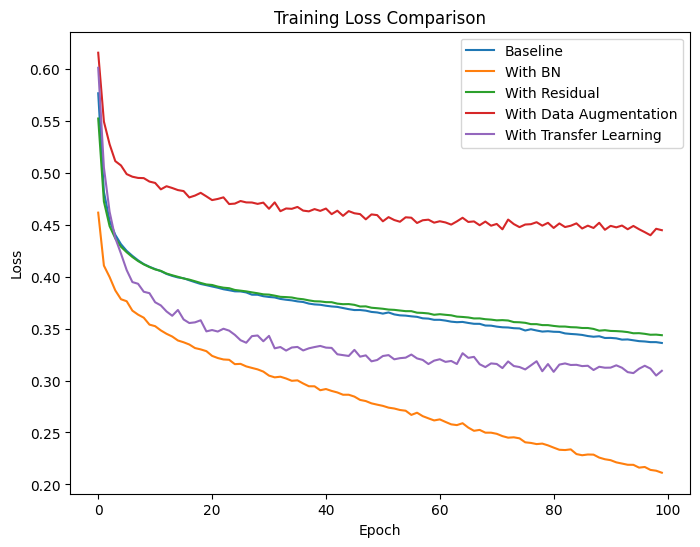

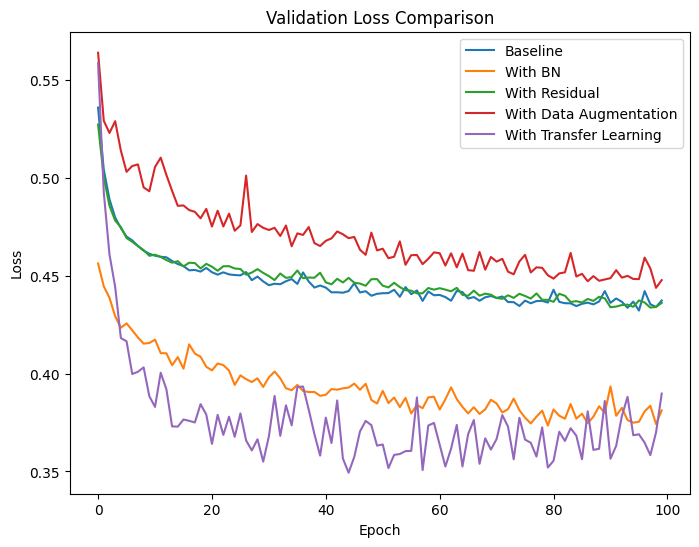

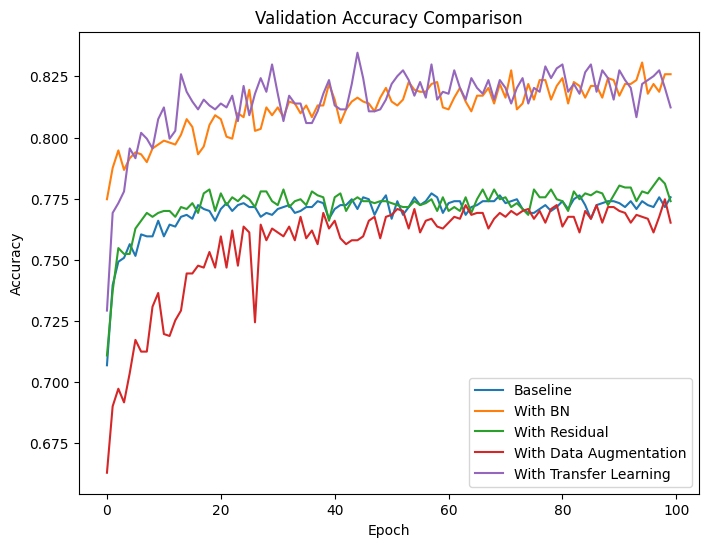

In [13]:
# 绘制训练损失对比
plt.figure(figsize=(8, 6))
for label, data in results.items():
    plt.plot(data['train_loss'], label=label)
plt.title('Training Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 绘制验证损失对比
plt.figure(figsize=(8, 6))
for label, data in results.items():
    plt.plot(data['val_loss'], label=label)
plt.title('Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 绘制验证准确率对比
plt.figure(figsize=(8, 6))
for label, data in results.items():
    plt.plot(data['val_accuracy'], label=label)
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()